In [1]:
## Inputs:

import numpy as np
import pandas as pd

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for clustering
from sklearn.cluster import KMeans




import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
#import shap
#import umap
import seaborn as sns
#import tensorflow as tf
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Input, Dense


In [2]:
sample_path = "/blue/carpena/haasehelen/ifwaste/output/conv_stores/run_0/"
filename = "aggregated_outputs.csv"

outputs = pd.read_csv( sample_path + filename) 
outputs.head()

,household,FGMEAT,FGDAIRY,FGVEGETABLE,FGDRYFOOD,FGSNACKS,FGBAKED,FGSTOREPREPARED,Inedible Parts,Plate Waste,...,Prepared,Unprepared,Preprepared,n_quickcook,n_cook,n_attempted_cook,n_leftovers,n_shop,n_quickshop,n_attempted_shop
0,81.0,41.611,277.836,48.279,33.209,219.150,39.689,710.478,128.409,753.993,...,545.993,113.782,710.478,16.0,73.0,11.0,93.0,5.0,63.0,15.0
1,34.0,79.419,78.544,116.789,85.362,148.909,172.717,458.422,111.206,625.989,...,450.266,231.474,458.422,14.0,67.0,19.0,86.0,1.0,76.0,26.0
2,173.0,228.469,144.440,193.550,140.186,103.160,155.026,383.415,238.277,558.042,...,504.608,460.223,383.415,10.0,72.0,18.0,92.0,10.0,63.0,10.0
3,423.0,337.633,111.655,253.704,173.166,264.361,419.664,387.065,209.694,1100.729,...,897.286,662.895,387.065,17.0,73.0,10.0,93.0,7.0,47.0,11.0
4,422.0,61.300,161.270,63.067,52.209,186.282,98.310,407.041,91.467,667.868,...,488.808,133.630,407.041,14.0,71.0,15.0,90.0,2.0,78.0,20.0


In [3]:
from sklearn import preprocessing

x = outputs.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
outputs_normalized = pd.DataFrame(x_scaled,columns=outputs.columns)
household_ids = outputs['household'].copy()
outputs_normalized = outputs_normalized.drop(columns=["household", "n_attempted_cook", "n_attempted_shop"])

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from collections import Counter

# Step 1: Prepare data and linkage
X = outputs_normalized.values if hasattr(outputs_normalized, "values") else outputs_normalized
Z = linkage(X, method='ward')
n_samples = X.shape[0]

def prepare_hierarchical_cluster(Z, n_clusters=None, distance=None):
    if n_clusters is not None:
        labels = fcluster(Z, t=n_clusters, criterion='maxclust')
        cut_distance = Z[-(n_clusters - 1), 2]
    elif distance is not None:
        labels = fcluster(Z, t=distance, criterion='distance')
        cut_distance = distance
        
    # Step 3: Count cluster sizes
    cluster_sizes = Counter(labels)
    print(f"\nSizes of the {n_clusters} clusters or {distance} distance:")
    for cluster_id, size in sorted(cluster_sizes.items()):
        print(f"  Cluster {cluster_id}: {size} samples")

    # Step 4: Plot dendrogram
    plt.figure(figsize=(14, 7))
    ddata = dendrogram(Z, color_threshold=cut_distance, no_labels=True)

    # Step 5: Annotate clusters
    # Create a mapping from original leaf index to cluster label
    ivl_order = list(map(int, ddata['ivl']))  # leaf order in plot
    label_mapping = {i: lbl for i, lbl in zip(range(1, n_samples + 1), labels)}

    # Find bounds of each cluster in the x-axis
    cluster_bounds = {}
    for x, leaf_id in enumerate(ivl_order):
        cluster_id = label_mapping[leaf_id + 1]  # +1 because fcluster is 1-based
        cluster_bounds.setdefault(cluster_id, []).append(x)

    # Place text above the midpoint of each cluster
    #for cluster_id, x_vals in cluster_bounds.items():
    #    midpoint = np.mean(x_vals)
    #    plt.text(midpoint, cut_distance + 2,  # slightly above cut line
    #             f"{cluster_sizes[cluster_id]}", 
    #             ha='center', va='bottom', fontsize=10, fontweight='bold',
    #             bbox=dict(boxstyle="round,pad=0.2", fc="lightyellow", ec="gray"))

    # Step 6: Final styling
    plt.axhline(y=cut_distance, color='red', linestyle='--', label=f'Cut at {cut_distance:.2f} (k={n_clusters})')
    plt.xticks(np.arange(0, n_samples, 50))
    plt.title("Dendrogram with Cluster Sizes Annotated")
    plt.xlabel("Sample Index")
    plt.ylabel("Distance")
    plt.legend()
    plt.tight_layout()
    plt.show()
    return labels


Sizes of the None clusters or 2 distance:
  Cluster 1: 23 samples
  Cluster 2: 60 samples
  Cluster 3: 65 samples
  Cluster 4: 39 samples
  Cluster 5: 78 samples
  Cluster 6: 92 samples
  Cluster 7: 31 samples
  Cluster 8: 129 samples
  Cluster 9: 90 samples
  Cluster 10: 48 samples
  Cluster 11: 73 samples
  Cluster 12: 12 samples
  Cluster 13: 7 samples
  Cluster 14: 15 samples
  Cluster 15: 6 samples
  Cluster 16: 69 samples
  Cluster 17: 107 samples
  Cluster 18: 54 samples
  Cluster 19: 49 samples
  Cluster 20: 31 samples
  Cluster 21: 74 samples


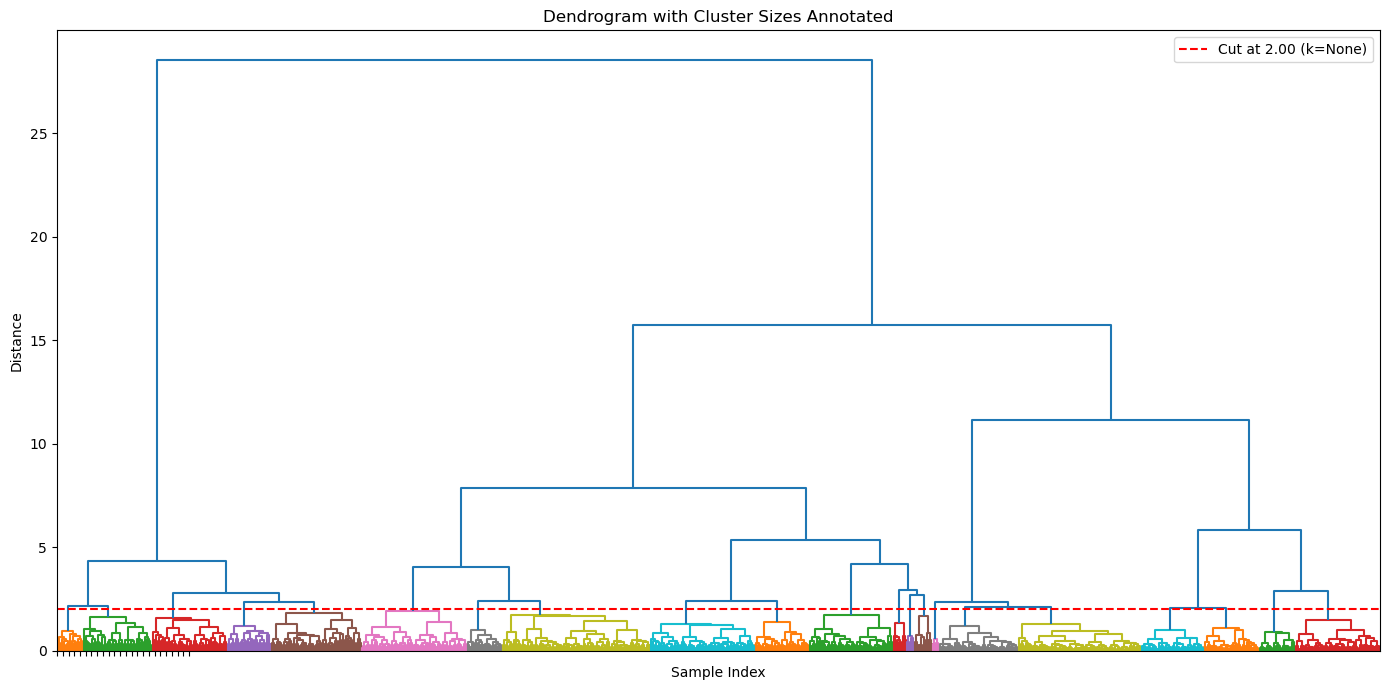

In [5]:
labels_d2 = prepare_hierarchical_cluster(Z,distance=2)


Sizes of the None clusters or 4 distance:
  Cluster 1: 83 samples
  Cluster 2: 182 samples
  Cluster 3: 92 samples
  Cluster 4: 160 samples
  Cluster 5: 138 samples
  Cluster 6: 73 samples
  Cluster 7: 34 samples
  Cluster 8: 182 samples
  Cluster 9: 103 samples
  Cluster 10: 105 samples


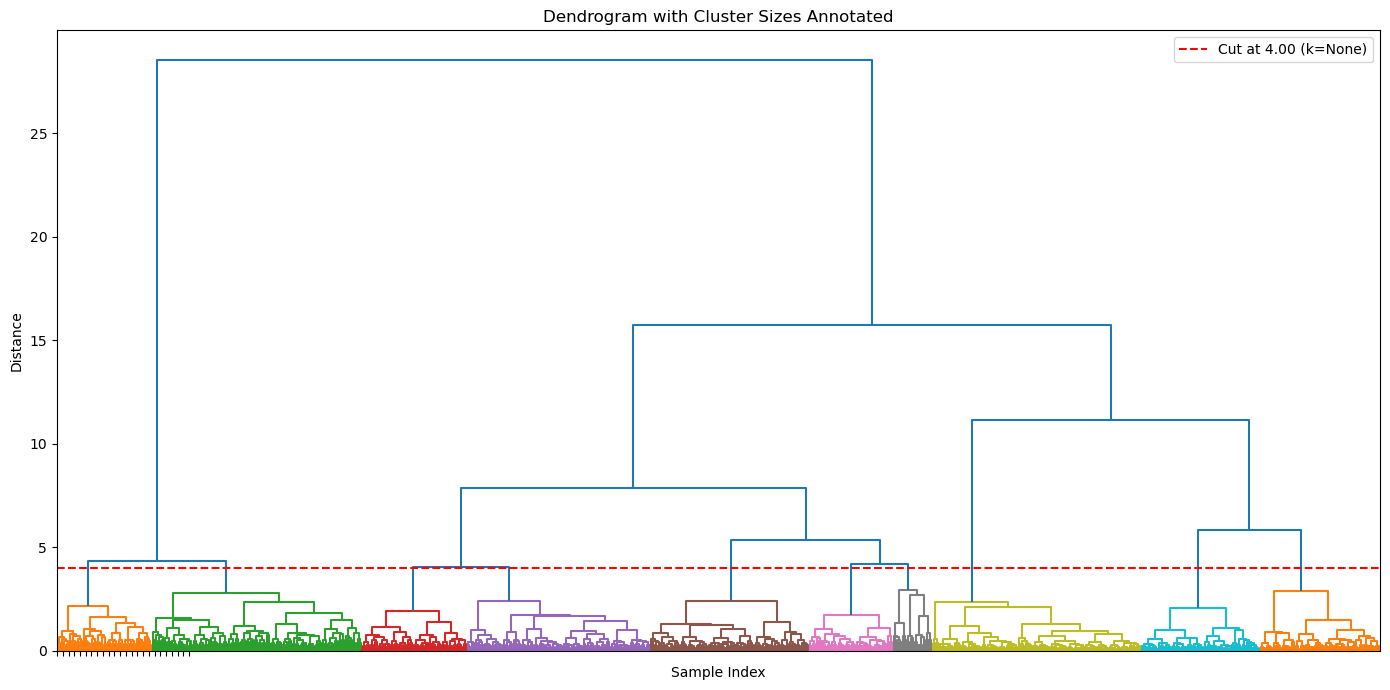

In [6]:
labels_d4 = prepare_hierarchical_cluster(Z,distance=4)


Sizes of the 8 clusters or None distance:
  Cluster 1: 83 samples
  Cluster 2: 182 samples
  Cluster 3: 252 samples
  Cluster 4: 138 samples
  Cluster 5: 107 samples
  Cluster 6: 182 samples
  Cluster 7: 103 samples
  Cluster 8: 105 samples


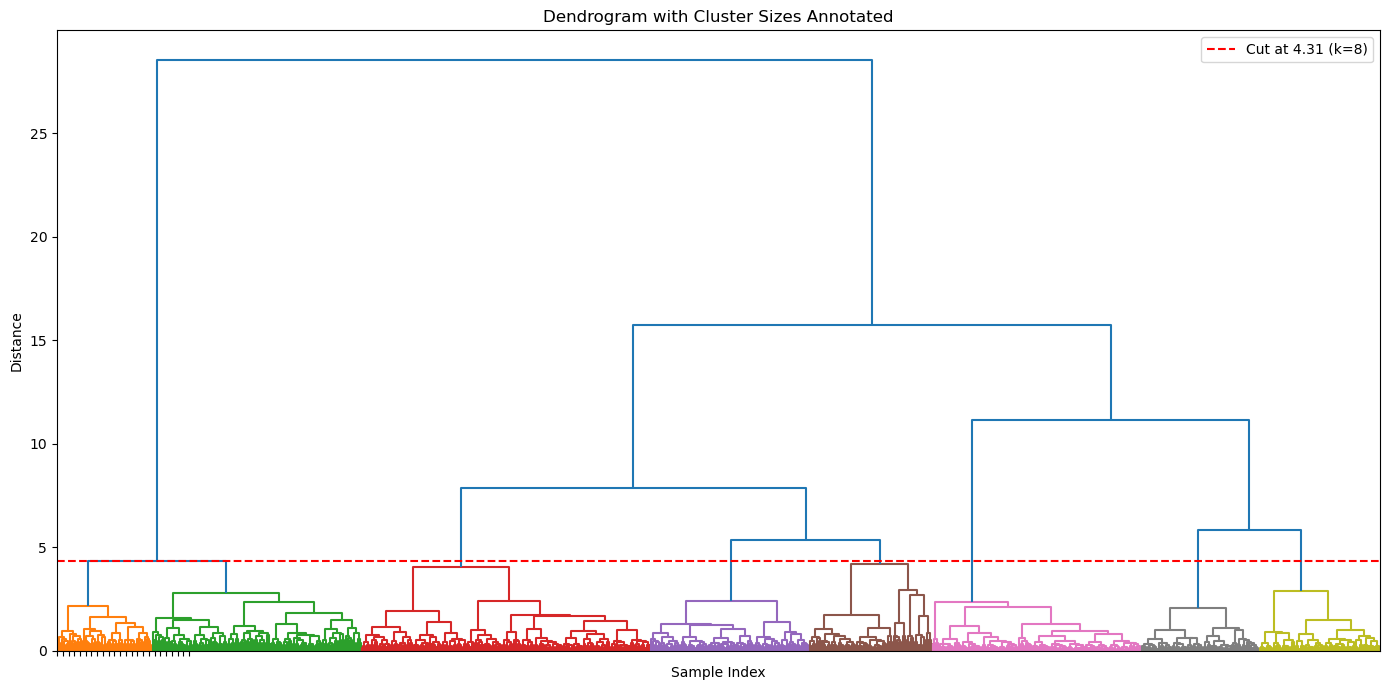

In [7]:
labels_c8 = prepare_hierarchical_cluster(Z,n_clusters=8)


Sizes of the 6 clusters or None distance:
  Cluster 1: 265 samples
  Cluster 2: 252 samples
  Cluster 3: 245 samples
  Cluster 4: 182 samples
  Cluster 5: 103 samples
  Cluster 6: 105 samples


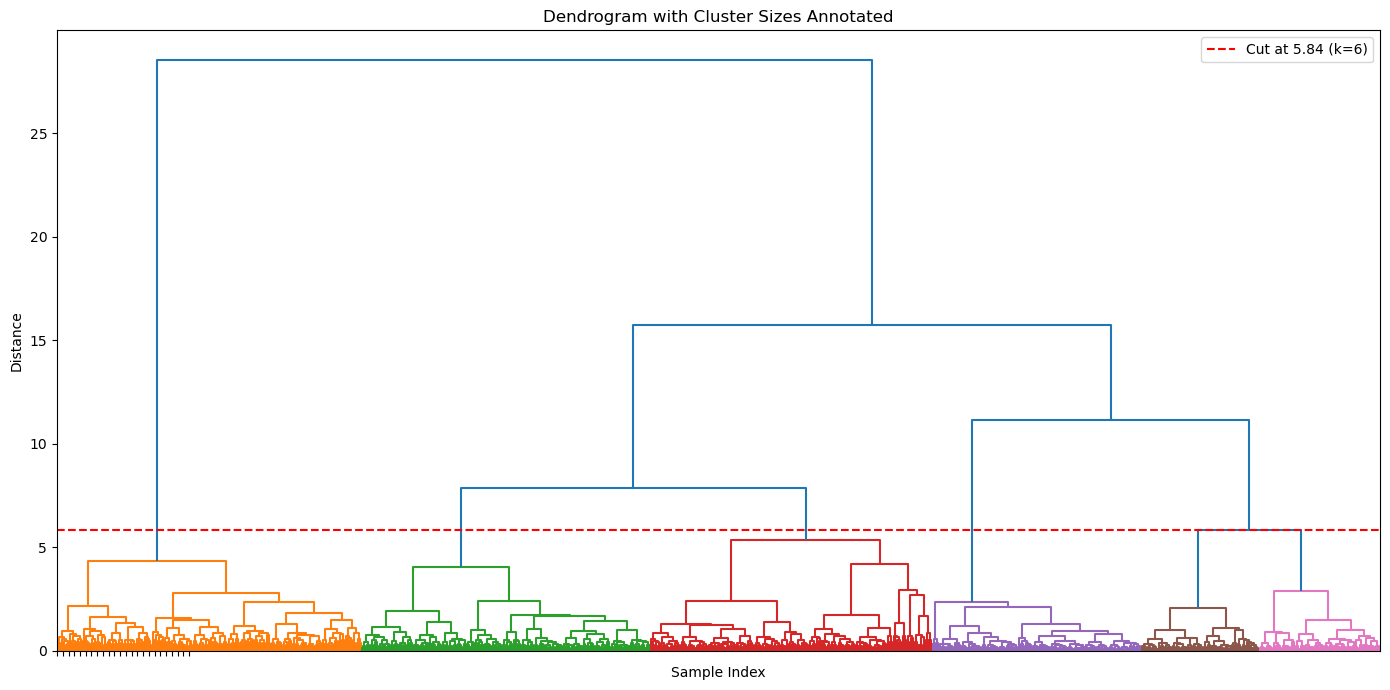

In [8]:
labels_c6 = prepare_hierarchical_cluster(Z,n_clusters=6)


Sizes of the 4 clusters or None distance:
  Cluster 1: 265 samples
  Cluster 2: 497 samples
  Cluster 3: 182 samples
  Cluster 4: 208 samples


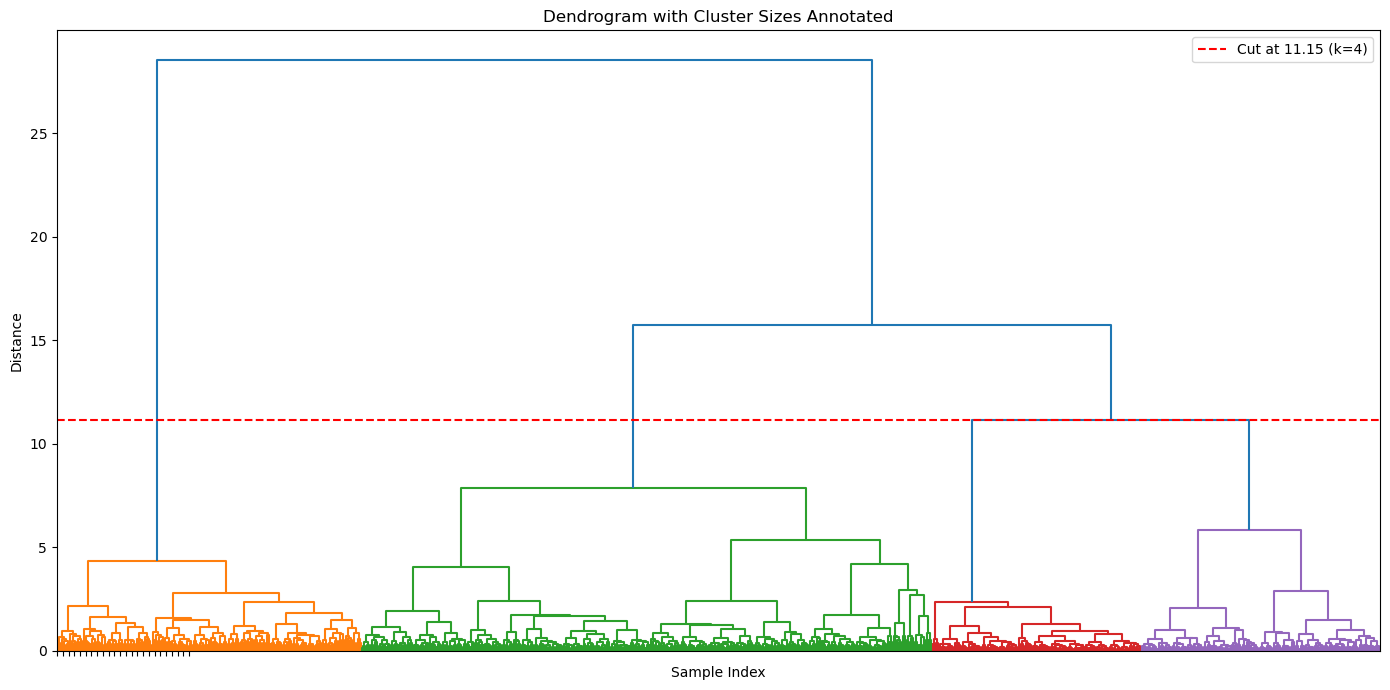

In [9]:
labels_c4 = prepare_hierarchical_cluster(Z,n_clusters=4)

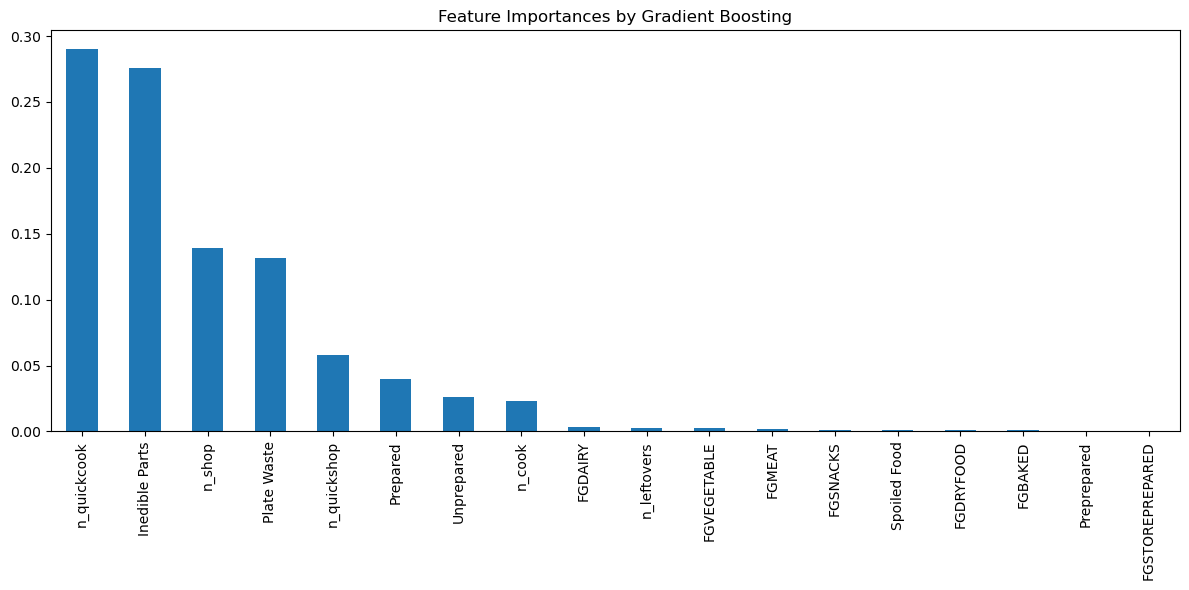

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd
import matplotlib.pyplot as plt
labels = labels_c6
# X = your features; labels = cluster IDs
clf = GradientBoostingClassifier()
clf.fit(outputs_normalized, labels)

# Feature importance
importances = pd.Series(clf.feature_importances_, index=outputs_normalized.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), title="Feature Importances by Gradient Boosting")
plt.tight_layout()
plt.show()


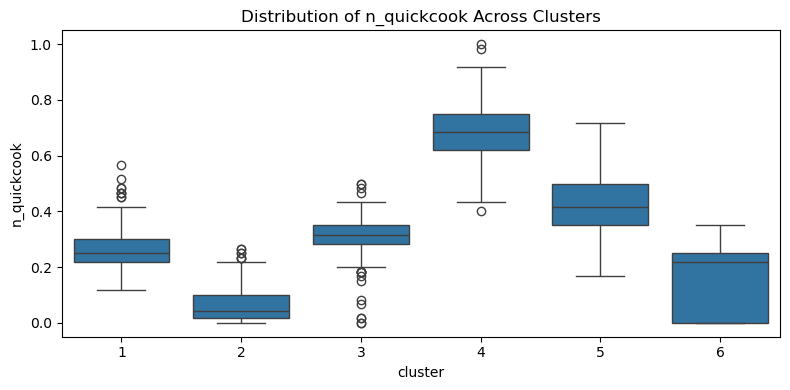

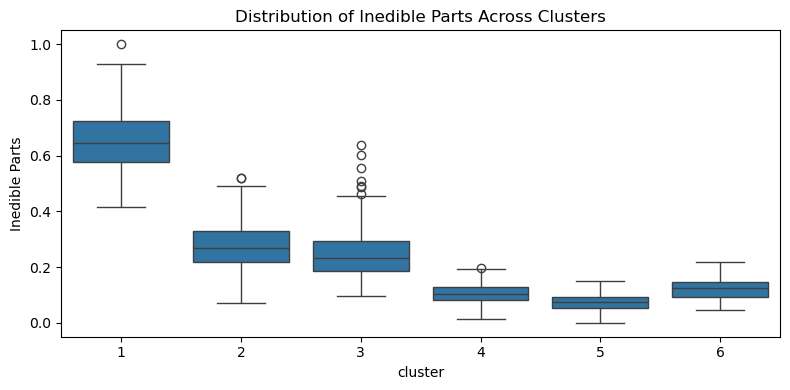

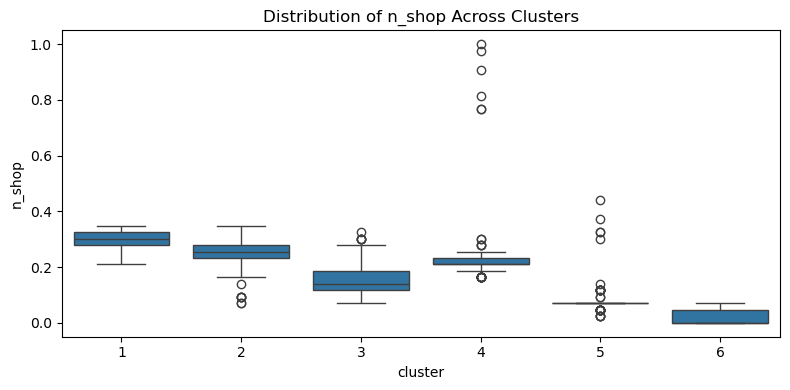

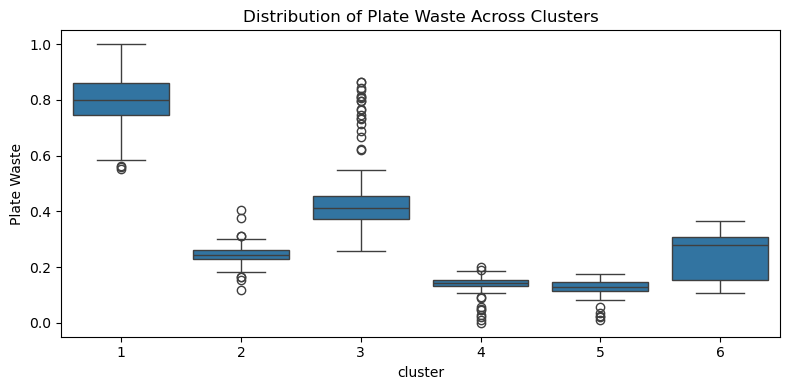

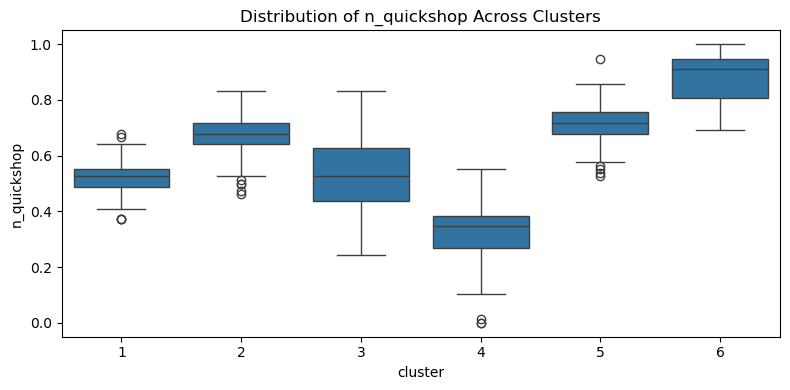

In [11]:
import seaborn as sns

# Melt for plotting
df_labeled = outputs_normalized.copy()
df_labeled['cluster'] = labels

# For each top feature
top_features = importances.sort_values(ascending=False).head(5).index

for feat in top_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='cluster', y=feat, data=df_labeled)
    plt.title(f"Distribution of {feat} Across Clusters")
    plt.tight_layout()
    plt.show()


In [12]:
labels = labels_c6
# Step 4: Reconstruct DataFrame with labels
outputs_labeled = pd.DataFrame({
    'household': household_ids,
    'cluster': labels
})

import ast

sample_path = "/blue/carpena/haasehelen/ifwaste/input/gsua_based_configuration/samples/"
df_h = pd.read_csv( sample_path + "household_ifwaste_sample_df.txt", sep="\t") 
#df_nh = pd.read_csv( sample_path + "neighborhood_ifwaste_sample_df.txt", sep="\t") 
#df_sim = pd.read_csv( sample_path + "household_ifwaste_sample_df.txt", sep="\t")
def expand_list_column(df, col):
    # Convert string representation of list to actual list
    expanded = df[col].apply(ast.literal_eval)

    # Find max list length
    max_len = expanded.apply(len).max()

    # Create new columns: col_1, col_2, ...
    new_cols = pd.DataFrame(expanded.tolist(), columns=[f"{col}_{i+1}" for i in range(max_len)])
    return new_cols

# Process each column
vector_columns = ["Household:hh_max_avail_time_per_day","Adult:adult_preference_vector","Child:child_preference_vector"]
flat_cols = [expand_list_column(df_h, col) for col in vector_columns]
df_h = df_h.drop(columns=vector_columns)

# Concatenate all the expanded columns together
df_flat = pd.concat(flat_cols, axis=1)
df_h = pd.concat([df_flat,df_h], axis=1)
inputs = df_h

x = inputs.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
inputs_normalized = pd.DataFrame(x_scaled,columns=inputs.columns)
inputs_normalized['household'] = inputs_normalized.index


input_with_clusters = inputs_normalized.merge(outputs_labeled, on='household', how='left')
labels = input_with_clusters["cluster"]
input_with_clusters = input_with_clusters.drop(columns=["household","cluster"])


In [13]:
input_with_clusters = input_with_clusters[:384]

In [14]:
input_with_clusters

,Household:hh_max_avail_time_per_day_1,Household:hh_max_avail_time_per_day_2,Household:hh_max_avail_time_per_day_3,Household:hh_max_avail_time_per_day_4,Household:hh_max_avail_time_per_day_5,Household:hh_max_avail_time_per_day_6,Household:hh_max_avail_time_per_day_7,Adult:adult_preference_vector_1,Adult:adult_preference_vector_2,Adult:adult_preference_vector_3,...,Adult:adult_plate_waste,Adult:male_store_prepared_ratio,Adult:female_store_prepared_ratio,Child:child_plate_waste,Child:male_store_prepared_ratio,Child:female_store_prepared_ratio,Cooking:cook_max_scaler_cooking_amount,Cooking:cook_expiration_threshold,Household:hh_shopping_frequency,Household:hh_pay_day_interval
0,1.000000,0.478873,0.260870,0.991736,0.281250,0.000000,0.452830,1.000000,0.000000,0.622222,...,1.00000,0.000000,0.342857,0.587302,0.558824,1.000000,0.982036,0.382353,1.000000,1.000000
1,1.000000,0.478873,0.260870,0.991736,0.281250,0.000000,0.452830,1.000000,0.000000,0.622222,...,1.00000,0.000000,0.342857,0.587302,0.558824,1.000000,0.982036,0.382353,1.000000,1.000000
2,1.000000,0.478873,0.260870,0.991736,0.281250,0.000000,0.452830,1.000000,0.000000,0.622222,...,1.00000,0.000000,0.342857,0.587302,0.558824,1.000000,0.982036,0.382353,1.000000,1.000000
3,1.000000,0.478873,0.260870,0.991736,0.281250,0.000000,0.452830,1.000000,0.000000,0.622222,...,1.00000,0.000000,0.342857,0.587302,0.558824,1.000000,0.982036,0.382353,1.000000,1.000000
4,1.000000,0.478873,0.260870,0.991736,0.281250,0.000000,0.452830,1.000000,0.000000,0.622222,...,1.00000,0.000000,0.342857,0.587302,0.558824,1.000000,0.982036,0.382353,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,0.038462,0.767606,0.000000,0.000000,0.117188,0.619835,0.075472,0.000000,0.355556,0.811111,...,0.00000,0.303030,1.000000,1.000000,0.441176,0.250000,0.742515,1.000000,0.714286,0.304348
380,0.038462,0.767606,0.000000,0.000000,0.117188,0.619835,0.075472,0.000000,0.355556,0.811111,...,0.00000,0.303030,1.000000,1.000000,0.441176,0.250000,0.742515,1.000000,0.714286,0.304348
381,0.038462,0.767606,0.000000,0.000000,0.117188,0.619835,0.075472,0.000000,0.355556,0.811111,...,0.00000,0.303030,1.000000,1.000000,0.441176,0.250000,0.742515,1.000000,0.714286,0.304348
382,0.638462,1.000000,0.173913,0.636364,0.875000,0.834711,0.245283,0.511905,0.655556,0.422222,...,0.97479,0.363636,0.885714,0.194444,0.823529,0.055556,0.137725,0.247059,1.000000,0.304348


In [15]:
# inputs_with_clusters is X
# labels = labels_c6

In [16]:
labels= labels[:384]

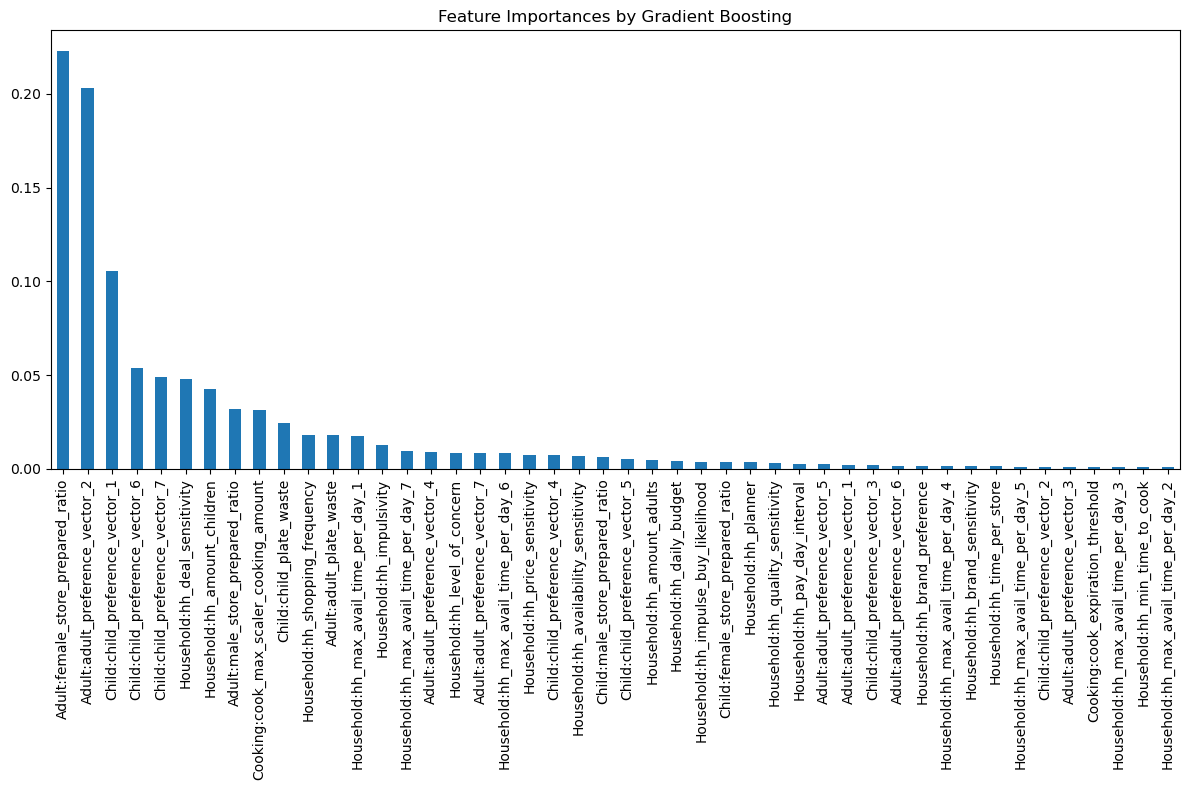

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator # Import MultipleLocator


# --- Your Original Code with Y-axis Tick Addition ---
# X = your features; labels = cluster IDs
clf = GradientBoostingClassifier(random_state=42) # Added random_state for reproducibility
clf.fit(input_with_clusters, labels)

# Feature importance
importances = pd.Series(clf.feature_importances_, index=input_with_clusters.columns)

# Sort and plot
fig, ax = plt.subplots(figsize=(12, 8)) # Create figure and axes explicitly for more control
importances.sort_values(ascending=False).plot(kind='bar', ax=ax, title="Feature Importances by Gradient Boosting")

plt.tight_layout()
plt.show()

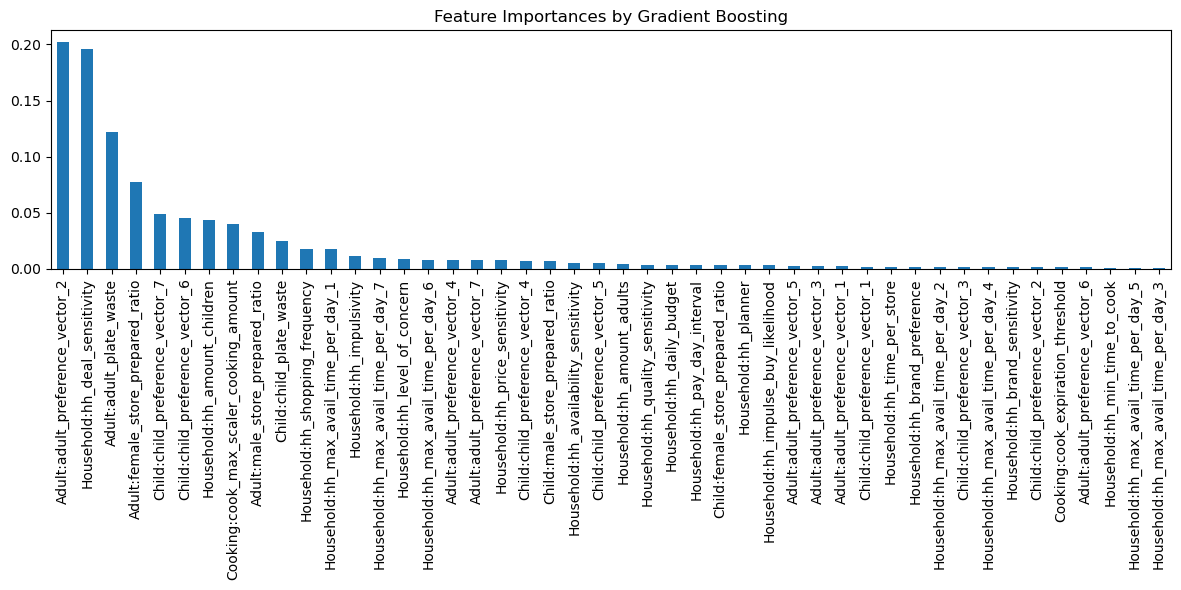

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd
import matplotlib.pyplot as plt
# X = your features; labels = cluster IDs
clf = GradientBoostingClassifier()
clf.fit(input_with_clusters, labels)

# Feature importance
importances = pd.Series(clf.feature_importances_, index=input_with_clusters.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), title="Feature Importances by Gradient Boosting")
plt.tight_layout()
plt.show()


In [19]:
importances = importances.sort_values(ascending=False)
importances

Adult:adult_preference_vector_2           0.202433
Household:hh_deal_sensitivity             0.195830
Adult:adult_plate_waste                   0.122338
Adult:female_store_prepared_ratio         0.077399
Child:child_preference_vector_7           0.049006
Child:child_preference_vector_6           0.045249
Household:hh_amount_children              0.043340
Cooking:cook_max_scaler_cooking_amount    0.039682
Adult:male_store_prepared_ratio           0.032528
Child:child_plate_waste                   0.024399
Household:hh_shopping_frequency           0.017741
Household:hh_max_avail_time_per_day_1     0.017625
Household:hh_impulsivity                  0.011266
Household:hh_max_avail_time_per_day_7     0.009296
Household:hh_level_of_concern             0.008795
Household:hh_max_avail_time_per_day_6     0.008254
Adult:adult_preference_vector_4           0.008110
Adult:adult_preference_vector_7           0.007819
Household:hh_price_sensitivity            0.007741
Child:child_preference_vector_4

In [20]:
df_labeled

,FGMEAT,FGDAIRY,FGVEGETABLE,FGDRYFOOD,FGSNACKS,FGBAKED,FGSTOREPREPARED,Inedible Parts,Plate Waste,Spoiled Food,Prepared,Unprepared,Preprepared,n_quickcook,n_cook,n_leftovers,n_shop,n_quickshop,cluster
0,0.028420,0.323796,0.039272,0.051714,0.358306,0.051344,0.475571,0.137758,0.345612,0.269333,0.268946,0.046714,0.475571,0.266667,0.634921,0.666667,0.116279,0.679487,3
1,0.067303,0.072594,0.095812,0.154041,0.235631,0.231348,0.298320,0.114215,0.283306,0.222470,0.216760,0.110095,0.298320,0.233333,0.539683,0.333333,0.023256,0.846154,6
2,0.220588,0.155654,0.159160,0.261609,0.155731,0.207410,0.245574,0.288115,0.250233,0.304708,0.246385,0.233285,0.245574,0.166667,0.619048,0.619048,0.232558,0.679487,2
3,0.332854,0.114330,0.208804,0.326318,0.437266,0.565500,0.248140,0.248998,0.514387,0.351578,0.460453,0.342431,0.248140,0.283333,0.634921,0.666667,0.162791,0.474359,3
4,0.048669,0.176868,0.051476,0.088993,0.300902,0.130666,0.262188,0.087202,0.303691,0.149140,0.237771,0.057403,0.262188,0.233333,0.603175,0.523810,0.046512,0.871795,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,0.029010,0.072133,0.162991,0.062256,0.075887,0.115611,0.225319,0.117540,0.140168,0.226806,0.104730,0.123842,0.225319,0.000000,0.666667,0.095238,0.000000,0.910256,6
1148,0.093575,0.315018,0.042279,0.041849,0.404202,0.008540,0.378365,0.218623,0.242298,0.304987,0.267758,0.074625,0.378365,0.200000,0.682540,0.761905,0.255814,0.717949,2
1149,0.169824,0.303129,0.113731,0.286898,0.361374,0.152319,0.335732,0.236877,0.418430,0.261983,0.385772,0.150795,0.335732,0.366667,0.539683,0.523810,0.139535,0.512821,3
1150,0.165237,0.268452,0.027879,0.220498,0.446081,0.100473,0.259317,0.165810,0.419778,0.140989,0.366059,0.084288,0.259317,0.383333,0.523810,0.571429,0.162791,0.448718,3


In [21]:
import seaborn as sns

# Melt for plotting
df_labeled = outputs_normalized.copy()
df_labeled['cluster'] = labels

# For each top feature
top_features = importances.sort_values(ascending=False).head(5).index

for feat in top_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='cluster', y=feat, data=df_labeled)
    plt.title(f"Distribution of {feat} Across Clusters")
    plt.tight_layout()
    plt.show()


ValueError: Could not interpret value `Adult:adult_preference_vector_2` for `y`. An entry with this name does not appear in `data`.

<Figure size 800x400 with 0 Axes>

In [ ]:
!pip install xgboost lightgbm

In [ ]:
labels = labels.apply(lambda x: int(x)-1)

In [ ]:
import xgboost as xgb
import shap
import pandas as pd
import matplotlib.pyplot as plt

model = xgb.XGBClassifier(
    objective='multi:softprob',  # outputs class probabilities
    num_class=6,                 # number of clusters
    eval_metric='mlogloss',
    random_state=42
)
model.fit(input_with_clusters, labels)

explainer = shap.TreeExplainer(model)
shap_values = explainer(input_with_clusters)  # List of arrays, one per class
shap.summary_plot(shap_values[0], input_with_clusters)    # SHAP values for class 0


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 640x480 with 0 Axes>

In [ ]:
print("Input shape:", input_with_clusters.shape)       # (n_samples, n_features)
print("SHAP values shape for class 0:", shap_values[0].shape)  # (n_samples, n_features) or (n_samples, n_features+1)
